<a id="top"></a>
# SCDA Hexagonal Aperture Generation Notebook

This notebook is used to generate hexagonal segmented apertures. 


## Package imports

In [1]:
#%matplotlib qt
import os
os.chdir('../..')
%matplotlib inline
from hcipy import *
from aplc_optimization.Inputs_Generation.SCDA_Inputs_Generation import make_SCDA_hex_aperture
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

## Parameters

In [2]:
filepath = 'masks/SCDA/'
N        = 1000 #Number of pixels in aperture, lyot stop, apodizer array
oversamp = 4  #oversampling factor in evaluate_supersampled [hcipy/field/util.py]. 
              #If set to 1 returns bw pupil. For gray set to > 1, nominally set to 4 (4 grey levels)

### Aperture parameters
Segmented pupil composed of hexagonal segments distributed over `num_rings` rings around the central
segment. 

All have a 15m circumscribed diameter, with 1.225 m diameter secondary obscurations and 0.006m edge gaps between segments.

In [3]:
#oversampling factor, black and white or grey pixels
if oversamp == 1:
    edge = 'bw'
elif oversamp > 1:
    edge = 'gy'

The 'clipped' flag, allows for the outer corner segments of the pupil to me omitted, to maximize the telescope geometry to render it as circular as possible and maximizing the diameter of the inscribed circle with respect to the overall diameter.

In [4]:
num_rings = 6 #number of rings of hexagons N around the central segment
clipped = True #whether to omit outer segments to form a more circular aperture

num_segments = 3*num_rings*(num_rings+1)+1
if clipped:
    num_segments = num_segments-6

print('Segmented pupil composed of {0} hexagonal segments distributed over {1} rings around the central segment.'.format(num_segments, num_rings))

Segmented pupil composed of 121 hexagonal segments distributed over 6 rings around the central segment.


### Lyot Stop parameters

In [5]:
pupil_diameter_inscribed = 13.5
lyot_ref_diam            = pupil_diameter_inscribed #diameter used to reference LS id and od against
ls_spid                  = True     #flag for inclusion or exclusion of struts in lyot stop
spid_ov                  = 2

In [6]:
LS_ID = [0.12]  #lyot stop inner diameter(s), relative to inscribed circle, 
                #re-normalized against circumscribed pupil in LS gen function
    
LS_OD = [0.982] #lyot stop outer diameter, relative to inscribed circle, 
                #re-normalized against circumscribed pupil in LS gen function

### Filepath and Filenames

### Construct aperture, write to fits

In [7]:
if clipped:
    pup_filename = 'TelAp_SCDA_{0:02d}-Hex_{1:s}_clipped_ovsamp{2:02d}__N{3:04d}.fits'.format(num_rings,edge,oversamp,N)
else:
    pup_filename = 'TelAp_SCDA_{0:02d}-Hex_{1:s}_ovsamp{2:02d}__N{3:04d}.fits'.format(num_rings,edge,oversamp,N)

grid                        = make_pupil_grid(N)
HEX_ap, aperture_header  = make_SCDA_hex_aperture(normalized=True, clipped = False, num_rings=num_rings, with_obstruction=True, with_spiders=False, return_header = True)
pupil                       = evaluate_supersampled(HEX_ap,grid,oversamp)

aperture_header['OVERSAMP'] = oversamp
aperture_header['EDGE']     = edge
aperture_header['D_INSC']   = pupil_diameter_inscribed
hdr = fits.Header()
hdr.set('TELESCOP', aperture_header['TELESCOP'])
hdr.set('D_CIRC', aperture_header['D_CIRC'],'m: circumscribed diameter')
hdr.set('D_INSC', aperture_header['D_INSC'],'m: inscribed diameter')
hdr.set('SEG_F2F',aperture_header['SEG_F2F_D'],'m: actual segment flat-to-flat diameter')
hdr.set('SEG_GAP',aperture_header['SEG_GAP'],'m: actual gap size between segments')
hdr.set('STRUT_W',aperture_header['STRUT_W'],'m: actual support strut width')
hdr.set('STRUT_ST',aperture_header['STRUT_ST'],'m: lower spider starting point d from center')
hdr.set('STRUT_AN',aperture_header['STRUT_AN'],'deg: angle lower spiders offset from vertical')
hdr.set('NORM',aperture_header['NORM'],'normalization keyword, OD scaled to 1 by Dcirc')
hdr.set('NUM_RINGS',aperture_header['NUM_RINGS'], 'number of rings of hexagons')
hdr.set('SEG_TRAN',aperture_header['SEG_TRAN'],'transmission for each of the segments')
#hdr.set('NUM_SEG',aperture_header['NUM_SEG'],'number of hexagonal segments')
hdr.set('EDGE',aperture_header['EDGE'],'black and white, or grey pixels')
hdr.set('OVERSAMP',aperture_header['OVERSAMP'],'oversampling factor, # grey levels')

fits.writeto(filepath+pup_filename, pupil.shaped, hdr,clobber=True)
print(filepath+pup_filename)


masks/SCDA/TelAp_SCDA_06-Hex_gy_clipped_ovsamp04__N1000.fits


### Construct lyot stop(s), write to fits

In [8]:
for ls_id in LS_ID:
    for ls_od in LS_OD:
        
        #filename key for struts or no struts
        if ls_spid:
            strut_key = 'struts'
        else:
            strut_key = 'no_struts'
    
        if ls_spid:
            ls_filename  = 'LS_LUVOIR_ID{0:04d}_OD{1:04d}_{2:s}_pad{3:02d}_{4:s}_ovsamp{5:d}_N{6:04d}.fits'.format(int(ls_id*1000),
                                                                                                int(ls_od*1000), \
                                                                                                strut_key, spid_ov,\
                                                                                                edge, oversamp, N)
        else:
            ls_filename  = 'LS_LUVOIR_ID{0:04d}_OD{1:04d}_{2:s}_{3:s}_ovsamp{4:d}_N{5:04d}.fits'.format(int(ls_id*1000), \
                                                                                                int(ls_od*1000), \
                                                                                                strut_key, edge, \
                                                                                                oversamp, N)

        LUVOIR_ls,ls_header = make_luvoir_a_lyot_stop(normalized=True, with_spiders=ls_spid, spider_oversize=spid_ov,
                                                      inner_diameter_fraction=ls_id, outer_diameter_fraction=ls_od, 
                                                      return_header=True)
        lyot_stop = evaluate_supersampled(LUVOIR_ls, grid, oversamp)
    
        hdr = fits.Header()
        ls_header['OVERSAMP'] = oversamp
        ls_header['EDGE']     = edge
        ls_header['D_INSC']   = pupil_diameter_inscribed
    
        hdr = fits.Header()
        hdr.set('TELESCOP', ls_header['TELESCOP'])
        hdr.set('D_CIRC', ls_header['D_CIRC'],'m: circumscribed diameter')
        hdr.set('D_INSC', ls_header['D_INSC'],'m: inscribed diameter')
        hdr.set('LS_REF_D',ls_header['LS_REF_D'],'m: used to reference given LS id and od')
    
        hdr.set('LS_ID', ls_header['LS_ID'], 'LS inner d, fraction of LS_REF_D')
        hdr.set('LS_OD', ls_header['LS_OD'], 'LS outer d, fraction of LS_REF_D')
    
        if ls_spid:
            hdr.set('STRUT_W',ls_header['STRUT_W'],'m: actual support strut width')
            hdr.set('STRUT_ST',ls_header['STRUT_ST'],'m: lower spider starting point d from center')
            hdr.set('STRUT_AN',ls_header['STRUT_AN'],'deg: angle lower spiders offset from vertical')
            hdr.set('STRUT_P',ls_header['STRUT_P'], 'spider padding factor')
   
        hdr.set('NORM',ls_header['NORM'],'normalization keyword, OD scaled to 1 by Dcirc')
        hdr.set('EDGE',ls_header['EDGE'],'black and white, or grey pixels')
        hdr.set('OVERSAMP',ls_header['OVERSAMP'],'oversampling factor, # grey levels')
    
        fits.writeto(filepath+ls_filename, lyot_stop.shaped, hdr, clobber=True)
    
        print(filepath+ls_filename)


masks/SCDA/LS_LUVOIR_ID0120_OD0982_struts_pad02_gy_ovsamp4_N1000.fits


### Plot aperture and lyot stop

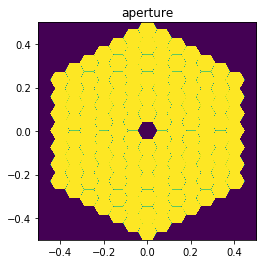

In [9]:
plt.figure()
plt.title('aperture')
imshow_field(pupil)
plt.show()

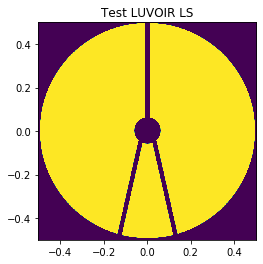

In [10]:
plt.figure()
plt.title('Test LUVOIR LS')
imshow_field(lyot_stop)
plt.show()

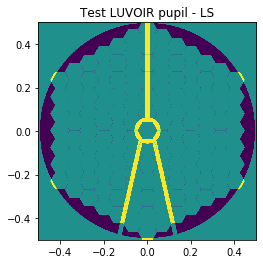

In [11]:
plt.figure()
plt.title('Test LUVOIR pupil - LS')
imshow_field(pupil-lyot_stop)
plt.show()

[Top of page](#top)